In [1]:
import dask.dataframe as dd

# Week 2.5

today we are checking out dask on a data set from interProScan protein 
Dask is a versatile Python parallel computing toolkit that offers high-level parallelism for analytics. It enables distributed computing and parallel processing, enabling you to work with enormous datasets effectively. Dask offers a high-level interface for working with huge datasets that take up more memory than a single system can hold.

The proteins' locations on the genome are included in the interProscan data.
Due to the size of the data frame, dask will be useful in providing insights.

In [2]:
# settign the dtypes
dtypes = {0:'string',
          1:'string',
          3:'string',
          4:'string',
          5:'string',
          6:'int',
          7:'int',
          8:'string',
          9:'string',
          11:'string',
          12:'string',
          13:'object',
          14:'object'}
 
header = ['protein_accesion', 'MD5', 'length', 'analysis', 
          'signature_accession', 'signature_description', 'start_loc', 
          'stop_loc', 'score', 'status', 'date', 'ip_annot_accession:feature',
          'ip_annot_desc', 'GO_values', 'description']
 
fields = range(15)
 
ddf = dd.read_table("/data/dataprocessing/interproscan/all_bacilli.tsv", dtype=dtypes, names=header, na_values='-')
                    # usecols = fields)
 
ddf.head()
# Code above is gathered from Javob Menzinga thnx :) 

,protein_accesion,MD5,length,analysis,signature_accession,signature_description,start_loc,stop_loc,score,status,date,ip_annot_accession:feature,ip_annot_desc,GO_values,description
0,gi|29898682|gb|AAP11954.1|,92d1264e347e149248231cb9b649388c,547,TIGRFAM,TIGR03882,cyclo_dehyd_2: bacteriocin biosynthesis cyclod...,2,131,1.6E-21,T,25-04-2022,IPR022291,"Bacteriocin biosynthesis, cyclodehydratase domain",NaN,NaN
1,gi|29898682|gb|AAP11954.1|,92d1264e347e149248231cb9b649388c,547,TIGRFAM,TIGR03604,TOMM_cyclo_SagD: thiazole/oxazole-forming pept...,161,547,0.0,T,25-04-2022,IPR027624,"Thiazole/oxazole-forming peptide maturase, Sag...",NaN,NaN
2,gi|29898682|gb|AAP11954.1|,92d1264e347e149248231cb9b649388c,547,ProSiteProfiles,PS51664,YcaO domain profile.,159,547,75.396477,T,25-04-2022,IPR003776,YcaO-like domain,NaN,NaN
3,gi|29898682|gb|AAP11954.1|,92d1264e347e149248231cb9b649388c,547,Gene3D,G3DSA:3.30.160.660,<NA>,311,452,9.1E-46,T,25-04-2022,<NA>,<NA>,NaN,NaN
4,gi|29898682|gb|AAP11954.1|,92d1264e347e149248231cb9b649388c,547,Gene3D,G3DSA:3.30.40.250,<NA>,191,274,9.1E-46,T,25-04-2022,<NA>,<NA>,NaN,NaN


The first question is:
- `How many distinct protein annotations are found in the dataset? I.e. how many distinc InterPRO numbers are there?` 
We can count the protein_accension unique values in the table to provide an answer to this query. this will accurately output a number that represents the various protein annotations.

In [3]:
distinct_annot = ddf.protein_accesion.nunique().compute()
print(f'The amount of unique annotations = {distinct_annot}')

The amount of unique annotations = 365570


The second question is:

- `How many annotations does a protein have on average?`

To anwer this question we need to count the number distict proteins and divede the number of rows with that number

In [4]:
num_row = ddf.shape[0].compute()
avg_per_protein = num_row / distinct_annot

print(f'average number of annotation per protein  = {avg_per_protein}')

average number of annotation per protein  = 11.490524386574391


The third question:

- `What is the most common GO Term found?` 

To answer this we need to check the accurance of the proteins and the bigest one is the most common search.


In [5]:
Go_term = ddf.GO_values.value_counts().compute()
print(f"The most common GO term = {Go_term}")

The most common GO term = GO:0003700|GO:0006355               33500
GO:0005524                          31164
GO:0003824                          23389
GO:0016491                          23362
GO:0005515                          20679
                                    ...  
GO:0005576|GO:0016811|GO:0071555        1
GO:0042802                              1
GO:0016021|GO:0055085|GO:0140359        1
GO:0042823|GO:0050570                   1
GO:0008959                              1
Name: GO_values, Length: 2447, dtype: int64


The fourth question:
- `What is the average size of an InterPRO feature found in the dataset?`

To respond, we must divide by the number of rows and subtract the start_loc from the end_loc. This will require patience cause the data is  very big

In [6]:
lenght_loci = ddf["stop_loc"] - ddf["start_loc"]
result = lenght_loci.mean().compute()

print(f"average lenght Interpro = {result}")

average lenght Interpro = 131.73178916966685


The fifth question:

- `What is the top 10 most common InterPRO features?`

Count and order ip_annot_accession:feature for the top 10



In [7]:
value_counts = ddf['ip_annot_accession:feature'].value_counts().compute()

top_10 = value_counts.nlargest(10)

print("top 10")
print(top_10)

top 10
IPR027417    46834
IPR002347    18077
IPR003439    16944
IPR036388    16291
IPR036259    12602
IPR003593    11521
IPR036390    11304
IPR036291    10716
IPR000515    10613
IPR001789    10471
Name: ip_annot_accession:feature, dtype: Int64


sixt question:

- `If you select InterPRO features that are almost the same size (within 90-100%) as the protein itself, what is the top10 then?`

Count lengt chech if is in the lengt of the protein and then sort by top 10
we will do this with only a small bit of the data.




In [15]:
ddf = ddf.get_partition(0)
ddf.head()

,protein_accesion,MD5,length,analysis,signature_accession,signature_description,start_loc,stop_loc,score,status,date,ip_annot_accession:feature,ip_annot_desc,GO_values,description,lengt_feature
0,gi|29898682|gb|AAP11954.1|,92d1264e347e149248231cb9b649388c,547,TIGRFAM,TIGR03882,cyclo_dehyd_2: bacteriocin biosynthesis cyclod...,2,131,1.6E-21,T,25-04-2022,IPR022291,"Bacteriocin biosynthesis, cyclodehydratase domain",NaN,NaN,129
1,gi|29898682|gb|AAP11954.1|,92d1264e347e149248231cb9b649388c,547,TIGRFAM,TIGR03604,TOMM_cyclo_SagD: thiazole/oxazole-forming pept...,161,547,0.0,T,25-04-2022,IPR027624,"Thiazole/oxazole-forming peptide maturase, Sag...",NaN,NaN,386
2,gi|29898682|gb|AAP11954.1|,92d1264e347e149248231cb9b649388c,547,ProSiteProfiles,PS51664,YcaO domain profile.,159,547,75.396477,T,25-04-2022,IPR003776,YcaO-like domain,NaN,NaN,388
3,gi|29898682|gb|AAP11954.1|,92d1264e347e149248231cb9b649388c,547,Gene3D,G3DSA:3.30.160.660,<NA>,311,452,9.1E-46,T,25-04-2022,<NA>,<NA>,NaN,NaN,141
4,gi|29898682|gb|AAP11954.1|,92d1264e347e149248231cb9b649388c,547,Gene3D,G3DSA:3.30.40.250,<NA>,191,274,9.1E-46,T,25-04-2022,<NA>,<NA>,NaN,NaN,83


In [18]:
ddf["lengt_feature"] = ddf["stop_loc"] - ddf["start_loc"] 

test = ddf[ddf["length"]*0.9 < ddf["lengt_feature"]]

value_counts= test["ip_annot_accession:feature"].value_counts().compute()

top_10 = value_counts.nlargest(10)

print("top 10:")
print(top_10)

top 10:
IPR036259    51
IPR027417    44
IPR000182    32
IPR029068    30
IPR020846    26
IPR016181    24
IPR036291    23
IPR029058    23
IPR036388    22
IPR029063    19
Name: ip_annot_accession:feature, dtype: Int64


question seven:
- `If you look at those features which also have textual annotation, what is the top 10 most common word found in that annotation?`

split the words and count them in the column ip_annot_desc

In [23]:
# Split the lines into individual words
test['words'] = test['ip_annot_desc'].str.split()

# Explode the list of words into separate rows
df = test.explode('words')

# Count the occurrences of each word and get the top 10
top_10_words = df['words'].value_counts().nlargest(10).compute()

# Print the top 10 words
print(top_10_words)

superfamily    584
protein        506
domain         451
family         126
transporter    110
Ribosomal      107
subunit         98
hydrolase       93
synthase        86
Protein         81
Name: words, dtype: int64


Question 8 

- `And the top 10 least common?`

same just use nsmallest


In [24]:
# Count the occurrences of each word and get the top 10
top_10_words = df['words'].value_counts().nsmallest(10).compute()

# Print the top 10 words
print(top_10_words)

Coenzyme                  1
nucleotidyltransferase    1
o                         1
S4                        1
Oxygen-insensitive        1
CoA-transferase,          1
Oxidoreductase            1
CoiA                      1
PRC-barrel                1
ClpB                      1
Name: words, dtype: int64


question aight:

- `Combining your answers for Q6 and Q7, what are the 10 most commons words found for the largest InterPRO features?` 

Checking in those features the word

In [33]:
top = ["IPR036259","IPR027417","IPR000182","IPR029068","IPR020846","IPR016181","IPR036291","IPR029058","IPR036388","IPR029063"]

new_df = ddf[ddf["ip_annot_accession:feature"].isin(top)]

# Split the lines into individual words
new_df['words'] = new_df['ip_annot_desc'].str.split()

# Explode the list of words into separate rows
df = new_df.explode('words')

# Count the occurrences of each word and get the top 10
top_10_words = df['words'].value_counts().nlargest(10).compute()

# Print the top 10 words
print(top_10_words)


superfamily     311
hydrolase       298
domain          261
triphosphate    258
nucleoside      258
P-loop          258
containing      258
GNAT             92
helix-like       84
DNA-binding      84
Name: words, dtype: int64


In [34]:
ddf.head()

,protein_accesion,MD5,length,analysis,signature_accession,signature_description,start_loc,stop_loc,score,status,date,ip_annot_accession:feature,ip_annot_desc,GO_values,description,lengt_feature,words
0,gi|29898682|gb|AAP11954.1|,92d1264e347e149248231cb9b649388c,547,TIGRFAM,TIGR03882,cyclo_dehyd_2: bacteriocin biosynthesis cyclod...,2,131,1.6E-21,T,25-04-2022,IPR022291,"Bacteriocin biosynthesis, cyclodehydratase domain",NaN,NaN,129,"[cyclo_dehyd_2:, bacteriocin, biosynthesis, cy..."
1,gi|29898682|gb|AAP11954.1|,92d1264e347e149248231cb9b649388c,547,TIGRFAM,TIGR03604,TOMM_cyclo_SagD: thiazole/oxazole-forming pept...,161,547,0.0,T,25-04-2022,IPR027624,"Thiazole/oxazole-forming peptide maturase, Sag...",NaN,NaN,386,"[TOMM_cyclo_SagD:, thiazole/oxazole-forming, p..."
2,gi|29898682|gb|AAP11954.1|,92d1264e347e149248231cb9b649388c,547,ProSiteProfiles,PS51664,YcaO domain profile.,159,547,75.396477,T,25-04-2022,IPR003776,YcaO-like domain,NaN,NaN,388,"[YcaO, domain, profile.]"
3,gi|29898682|gb|AAP11954.1|,92d1264e347e149248231cb9b649388c,547,Gene3D,G3DSA:3.30.160.660,<NA>,311,452,9.1E-46,T,25-04-2022,<NA>,<NA>,NaN,NaN,141,<NA>
4,gi|29898682|gb|AAP11954.1|,92d1264e347e149248231cb9b649388c,547,Gene3D,G3DSA:3.30.40.250,<NA>,191,274,9.1E-46,T,25-04-2022,<NA>,<NA>,NaN,NaN,83,<NA>


question 10:

- `What is the coefficient of correlation () between the size of the protein and the number of features found?`

Count the number of features per protein and save the lengt plot cor the results

In [39]:
def get_unique_length(series):
    return series.unique().tolist()

In [69]:


# Group by 'protein_accession', count 'signature_accession', and get unique 'length' values
grouped_df = ddf.groupby('protein_accesion')["ip_annot_accession:feature"].count().compute()

num_features = list(grouped_df)

lenght_df = ddf.groupby('protein_accesion')["length"].unique().compute()

lengte_prot = [int(x) for x in lenght_df]


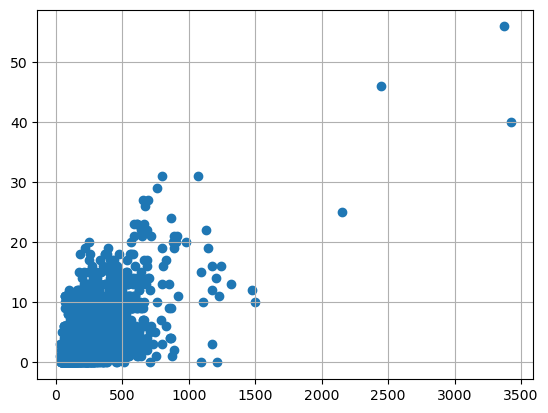

In [75]:
import matplotlib.pyplot as plt

plt.scatter(lengte_prot,num_features)
plt.grid()
